# Solutions 3 - Examples in Singular Value Decomposition

## Assignment 1

All functions from previous notebooks are collected in the file `ModuleB.jl` which contains the module `ModuleB`. 

In [1]:
include("ModuleB.jl")
using ModuleB

## Assignment 2

You can see the availabe images at http://timholy.github.io/TestImages.jl/.

After installing the package with `Pkg.add("TestImages")`, the images are located in the directory `.julia/v0.6/TestImages/images`.

In [2]:
using TestImages, Images

In [3]:
whos(TestImages)

                    TestImages   4506 bytes  Module
                     testimage      0 bytes  TestImages.#testimage


In [4]:
# whos(Images)

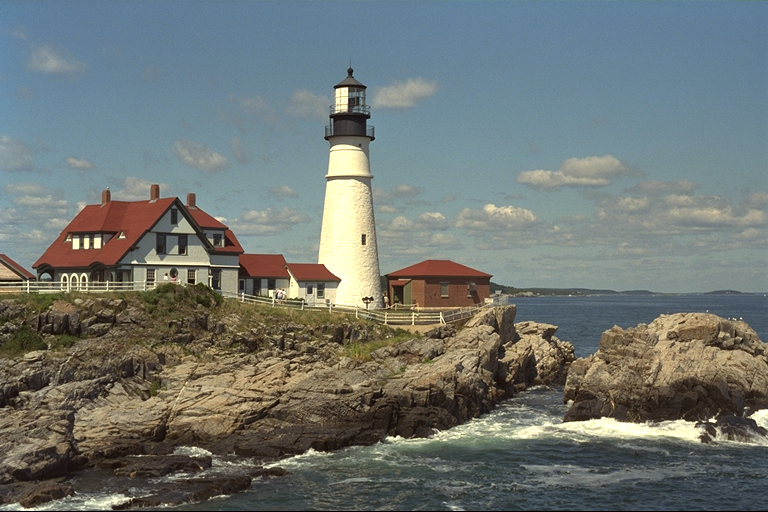

In [5]:
img=testimage("lighthouse")

In [6]:
# For example
img[1,1]

In [7]:
show(img[1,1])

RGB{N0f8}(0.361,0.486,0.6)

In [8]:
# Separate the image into R, G and B components
imgsep=float(channelview(img))

3×512×768 Array{Float32,3}:
[:, :, 1] =
 0.360784  0.360784  0.376471  0.364706  …  0.701961  0.458824  0.443137  0.0
 0.486275  0.486275  0.513726  0.498039     0.745098  0.486275  0.466667  0.0
 0.6       0.6       0.623529  0.619608     0.678431  0.447059  0.439216  0.0

[:, :, 2] =
 0.34902   0.360784  0.352941  0.368627  …  0.678431  0.427451  0.443137  0.0
 0.47451   0.498039  0.490196  0.505882     0.721569  0.466667  0.466667  0.0
 0.588235  0.607843  0.607843  0.623529     0.666667  0.423529  0.439216  0.0

[:, :, 3] =
 0.345098  0.360784  0.360784  0.364706  …  0.615686  0.513726  0.486275  0.0
 0.478431  0.494118  0.494118  0.498039     0.654902  0.552941  0.52549   0.0
 0.588235  0.615686  0.615686  0.619608     0.611765  0.517647  0.490196  0.0

...

[:, :, 766] =
 0.329412  0.356863  0.356863  0.34902   …  0.258824  0.192157  0.172549  0.0
 0.462745  0.486275  0.482353  0.47451      0.309804  0.231373  0.203922  0.0
 0.517647  0.568627  0.596078  0.588235     0.341176  0.

In [9]:
R=imgsep[1,:,:]
G=imgsep[2,:,:]
B=imgsep[3,:,:]

512×768 Array{Float32,2}:
 0.6       0.588235  0.588235  0.623529  …  0.517647  0.52549   0.529412
 0.6       0.607843  0.615686  0.607843     0.568627  0.564706  0.580392
 0.623529  0.607843  0.615686  0.615686     0.596078  0.596078  0.607843
 0.619608  0.623529  0.619608  0.615686     0.588235  0.6       0.588235
 0.627451  0.639216  0.615686  0.619608     0.6       0.607843  0.596078
 0.635294  0.631373  0.619608  0.619608  …  0.596078  0.611765  0.611765
 0.635294  0.619608  0.623529  0.619608     0.6       0.607843  0.611765
 0.635294  0.619608  0.607843  0.623529     0.6       0.588235  0.615686
 0.627451  0.631373  0.631373  0.623529     0.6       0.596078  0.603922
 0.619608  0.631373  0.627451  0.643137     0.603922  0.596078  0.603922
 0.643137  0.631373  0.623529  0.635294  …  0.607843  0.596078  0.592157
 0.658824  0.623529  0.623529  0.635294     0.592157  0.596078  0.607843
 0.643137  0.65098   0.639216  0.635294     0.588235  0.6       0.623529
 ⋮                       

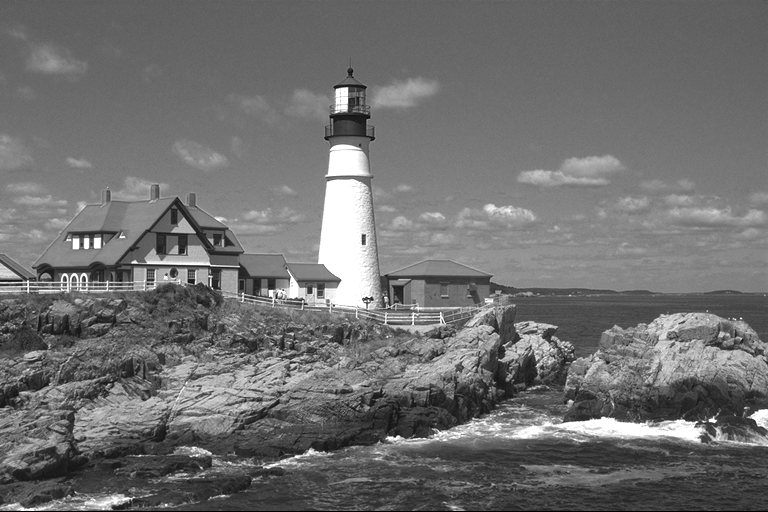

In [10]:
# Let us take a look at the red component
colorview(Gray,R)

In [11]:
# Compute the SVD of each component
UR,σR,VR=svd(R)
UG,σG,VG=svd(G)
UB,σB,VB=svd(B);

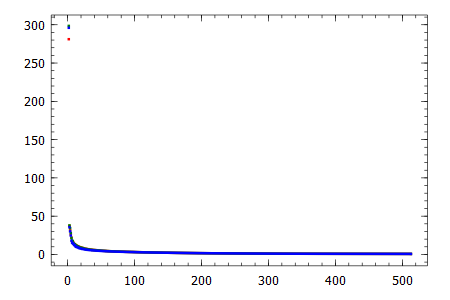

In [12]:
# Plot the singular values
using Winston
x=collect(1:minimum(size(img)))
plot(x,σR,"r.",x,σG,"g.",x,σB,"b.")

In [13]:
using Interact

INFO: Interact.jl: using new nbwidgetsextension protocol


Interact.Slider{Int64}(1: "input" = 150 Int64 , "", 150, 1:300, "horizontal", true, "d", true)

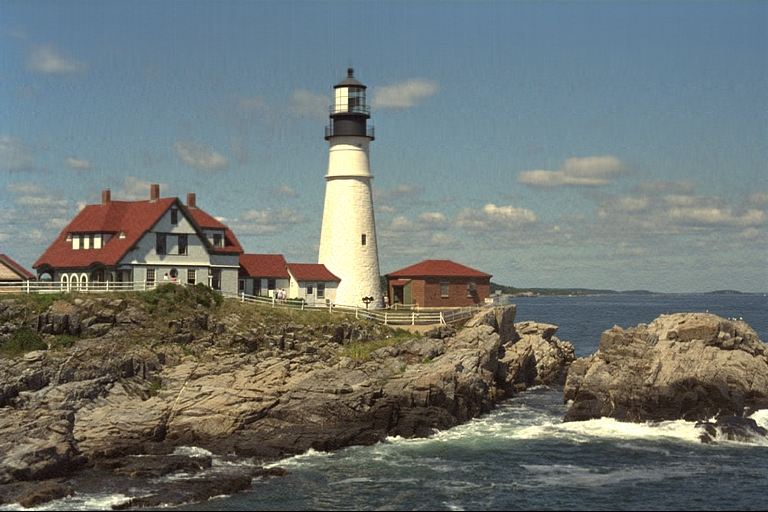

In [14]:
# Watch the compression quality
@manipulate for  k in slider(1:300,value=150)
    Rc=UR[:,1:k]*diagm(σR[1:k])*VR[:,1:k]'
    Gc=UG[:,1:k]*diagm(σG[1:k])*VG[:,1:k]'
    Bc=UB[:,1:k]*diagm(σB[1:k])*VB[:,1:k]'
    colorview(RGB, Rc, Gc, Bc)
end

## Assignment 3

In [15]:
# Part of the preamble of lapack.jl
const liblapack = Base.liblapack_name
import Base.LinAlg.BLAS.@blasfunc
import Base.LinAlg.BlasInt
function chklapackerror(ret::BlasInt)
    if ret == 0
        return
    elseif ret < 0
        throw(ArgumentError("invalid argument #$(-ret) to LAPACK call"))
    else # ret > 0
        throw(LAPACKException(ret))
    end
end

chklapackerror (generic function with 1 method)

In [16]:
for (gesvj, elty) in
    ((:dgesvj_,:Float64),
    (:sgesvj_,:Float32))
    @eval begin
        function gesvj!(A::Array{$elty})
            joba='G'
            jobu='U'
            jobv='V'
            m,n = size(A)
            lda=m
            sva=Array{$elty}(n)
            mv=1
            V=Array{$elty}(n,n)
            ldv=n
            lwork=max(6,m+n)
            work = Array{$elty}(lwork)
            info = Array{BlasInt}(1)
            ccall((@blasfunc($gesvj), liblapack), Void,
            (Ptr{UInt8}, Ptr{UInt8}, Ptr{UInt8}, 
            Ptr{BlasInt}, Ptr{BlasInt}, Ptr{$elty},
            Ptr{BlasInt}, Ptr{$elty}, Ptr{BlasInt},
            Ptr{$elty}, Ptr{BlasInt}, Ptr{$elty},
            Ptr{BlasInt}, Ptr{BlasInt}),
                &joba, &jobu, &jobv, 
                &m, &n, A, 
                &lda, sva, &mv,
                V, &ldv, work, 
                &lwork, info)
                chklapackerror(info[])
            A, sva, V
        end
    end
end

In [17]:
# Small, strongly scaled matrix
m=20
n=15
s=srand(421)
B=rand(m,n)
D=exp.(80*(rand(n)-0.5))
A=B*diagm(D);

In [18]:
U,σ,V=ModuleB.myJacobiR(A)
U₁,σ₁,V₁=gesvj!(copy(A))
(sort(σ,rev=true)-σ₁)./σ₁

15-element Array{Float64,1}:
  4.2684e-16 
  6.07874e-16
  5.62195e-16
  5.42208e-16
  4.93734e-16
  2.65406e-16
  1.04521e-15
  5.41749e-16
  4.83433e-16
  6.66446e-16
  5.6235e-16 
  3.52605e-16
 -6.57183e-16
  0.0        
  0.0        

In [19]:
# Timing for large matrices
n=1000
A=rand(n,n)
@time svd(A);
@time gesvj!(A);

  1.130657 seconds (31.91 k allocations: 55.191 MiB, 1.68% gc time)
  7.286223 seconds (10 allocations: 7.653 MiB)
